In [1]:
import os

SOURCE_URL = 'https://storage.googleapis.com/dm-turtle-recall/images.tar'
IMAGE_DIR = './turtle_recall/images'
TAR_PATH = os.path.join(IMAGE_DIR, os.path.basename(SOURCE_URL))
EXPECTED_IMAGE_COUNT = 13891

%sx mkdir --parents "{IMAGE_DIR}"
if len(os.listdir(IMAGE_DIR)) != EXPECTED_IMAGE_COUNT:
    %sx wget --no-check-certificate -O "{TAR_PATH}" "{SOURCE_URL}"
    %sx tar --extract --file="{TAR_PATH}" --directory="{IMAGE_DIR}"
    %sx rm "{TAR_PATH}"
    
print(f'The total number of images is: {len(os.listdir(IMAGE_DIR))}')

The total number of images is: 13891


In [2]:
# Installing Dependencies on SUTD Cluster
!pip install seaborn
!pip install albumentations
!pip install --upgrade tensorflow_datasets

!pip uninstall --yes opencv-python
!pip uninstall --yes opencv-python-headless
!pip install opencv-python
!pip install opencv-python-headless==4.1.2.30 

Requirement already up-to-date: tensorflow_datasets in /opt/conda/lib/python3.6/site-packages (4.5.2)
Found existing installation: opencv-python 4.5.5.64
Uninstalling opencv-python-4.5.5.64:
  Successfully uninstalled opencv-python-4.5.5.64
Found existing installation: opencv-python-headless 4.1.2.30
Uninstalling opencv-python-headless-4.1.2.30:
  Successfully uninstalled opencv-python-headless-4.1.2.30
  Using cached opencv_python-4.5.5.64-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.5 MB)
  Using cached opencv_python_headless-4.1.2.30-cp36-cp36m-manylinux1_x86_64.whl (21.8 MB)


In [3]:
import pandas as pd
import requests
import io
import urllib.parse

BASE_URL = 'https://storage.googleapis.com/dm-turtle-recall/'


def read_csv_from_web(file_name):
  url = urllib.parse.urljoin(BASE_URL, file_name)
  content = requests.get(url).content
  return pd.read_csv(io.StringIO(content.decode('utf-8')))

# Read in csv files.
train = read_csv_from_web('train.csv')
test = read_csv_from_web('test.csv')
sample_submission = read_csv_from_web('sample_submission.csv')

# Convert image_location strings to lowercase.
for df in [train, test]:
  df.image_location = df.image_location.apply(lambda x: x.lower())
  assert set(df.image_location.unique()) == set(['left', 'right', 'top'])

In [4]:
train.head()

,image_id,image_location,turtle_id
0,ID_2RK4WLN8,top,t_id_VP2NW7aV
1,ID_VVW0QXLX,left,t_id_qZ0iZYsC
2,ID_RVATH2HZ,right,t_id_3b65X5Lw
3,ID_2GB90GPS,left,t_id_YjXYTCGC
4,ID_LM6S0B1M,top,t_id_d6aYXtor


In [6]:
train.shape, test.shape

((2145, 3), (490, 2))

In [7]:
print(f"There are {train.turtle_id.nunique()} unique turtles in the train set.")

There are 100 unique turtles in the train set.


In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train_images_per_turtle = pd.value_counts(train['turtle_id'])

In [9]:
print(train_images_per_turtle)

t_id_ROFhVsy2    77
t_id_hRzOoJ2t    68
t_id_VP2NW7aV    58
t_id_Kf73l69A    57
t_id_dVQ4x3wz    47
                 ..
t_id_Lhp87PBX    10
t_id_4XiPKIk7    10
t_id_p77GDtzg     9
t_id_OqU1NWEA     9
t_id_J5dngbNA     8
Name: turtle_id, Length: 100, dtype: int64


In [10]:
import functools
from PIL import Image  # Image utilities.
import tqdm
import numpy as np

In [11]:
pd.unique(train['turtle_id'])

array(['t_id_VP2NW7aV', 't_id_qZ0iZYsC', 't_id_3b65X5Lw', 't_id_YjXYTCGC',
       't_id_d6aYXtor', 't_id_ksTLswDT', 't_id_hRzOoJ2t', 't_id_utw0thCe',
       't_id_k1rScFLB', 't_id_n2FBHk6d', 't_id_ZfvZBX4Q', 't_id_G5eoqwD8',
       't_id_FBsGDJhU', 't_id_Ts5LyVQz', 't_id_NW7wn8TC', 't_id_JI6ba2Yx',
       't_id_ifWwxWF4', 't_id_uIlC9Gfo', 't_id_dVQ4x3wz', 't_id_3K93fQBS',
       't_id_IlO9BOKc', 't_id_DPYQnZyv', 't_id_ROFhVsy2', 't_id_BI99coHt',
       't_id_GrxmyS59', 't_id_AOWArhGb', 't_id_4XiPKIk7', 't_id_mpuNp8mf',
       't_id_stWei2Uq', 't_id_15bo4NKD', 't_id_QqeoI5F3', 't_id_Kf73l69A',
       't_id_Kc1tXDbJ', 't_id_2Yn71r7R', 't_id_iZQiE7wb', 't_id_m2JvEcsg',
       't_id_a4VYrmyA', 't_id_UVQa4BMz', 't_id_tjWepji1', 't_id_BXWccqAn',
       't_id_1KIezxkh', 't_id_e9i3Lbq4', 't_id_bYageLYA', 't_id_8b8sprYe',
       't_id_2QmcRkNj', 't_id_9GFmcOd5', 't_id_smNwfXAT', 't_id_hibDzPAP',
       't_id_D3kHUEgp', 't_id_B7LaSiac', 't_id_fjHGjp1w', 't_id_gJaKYxBQ',
       't_id_72SiiZCp', '

In [12]:
extra = pd.read_csv("./input/extra_images_common_updated.csv")
train = pd.concat([train,extra])
train = train.reset_index()
train.pop("index")
print(train.shape)

(2784, 3)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train['image_id'], train['turtle_id'], test_size=0.10, random_state=42, stratify=train['turtle_id'])

# print(X_train.shape, X_test.shape, X_val.shape ,y_train.shape, y_test.shape, y_val.shape)

train_ds = pd.concat([X_train, y_train], axis=1)
train_ds['type'] = "train"
val_ds = pd.concat([X_val, y_val], axis=1)
val_ds['type'] = "val"
# test_ds = pd.concat([X_test, y_test], axis=1)
# test_ds['type'] = "test"

In [14]:
#full dataset
train_ds = train_ds

In [15]:
train_ds

,image_id,turtle_id,type
2419,ID_GQ4O0LH7,t_id_hRzOoJ2t,train
1220,ID_KEW845NU,t_id_IP1t15lD,train
2361,ID_CWBLZ1IT,t_id_dVQ4x3wz,train
2316,ID_ACMP57DU,t_id_GrxmyS59,train
621,ID_DT2BDLSE,t_id_hRzOoJ2t,train
...,...,...,...
1870,ID_2WZGLEX7,t_id_BI99coHt,train
1541,ID_QPP4C9R6,t_id_KysHzQQK,train
345,ID_YK0MNJ2N,t_id_1KIezxkh,train
0,ID_2RK4WLN8,t_id_VP2NW7aV,train


In [16]:
x_train_images_per_turtle = pd.value_counts(train_ds['turtle_id'])
print(x_train_images_per_turtle)
print(x_train_images_per_turtle.mean())

t_id_dVQ4x3wz    103
t_id_ROFhVsy2     99
t_id_hRzOoJ2t     78
t_id_YjXYTCGC     64
t_id_VP2NW7aV     62
                ... 
t_id_0DPPpRUz     10
t_id_gz3whk0q      9
t_id_Dv4O8bOM      9
t_id_p77GDtzg      8
t_id_OqU1NWEA      8
Name: turtle_id, Length: 100, dtype: int64
25.05


In [17]:
val_ds

,image_id,turtle_id,type
2660,ID_TYOUCWB5,t_id_YjXYTCGC,val
977,ID_58YOXVJA,t_id_Kf73l69A,val
327,ID_JG2X5YIW,t_id_hRzOoJ2t,val
1148,ID_R1N5MLUC,t_id_ksTLswDT,val
1114,ID_UZCHV7U9,t_id_8b8sprYe,val
...,...,...,...
950,ID_RK5AVSOO,t_id_ksTLswDT,val
333,ID_KCU00M6B,t_id_ROFhVsy2,val
170,ID_EAY71H9C,t_id_G5JLzvai,val
2495,ID_LNRLOJW4,t_id_a4VYrmyA,val


## Uniform Sampling

In [18]:
# mean = round(x_train_images_per_turtle.mean())

#Setting the mean as the maximum number of images
mean = round(x_train_images_per_turtle.max())
print('The mean is {}'.format(mean))
majority = x_train_images_per_turtle[x_train_images_per_turtle>(mean-1)]
print(majority.shape)
print(majority)
minority = x_train_images_per_turtle[x_train_images_per_turtle<mean]
print(minority.shape)
print(minority)

The mean is 103
(1,)
t_id_dVQ4x3wz    103
Name: turtle_id, dtype: int64
(99,)
t_id_ROFhVsy2    99
t_id_hRzOoJ2t    78
t_id_YjXYTCGC    64
t_id_VP2NW7aV    62
t_id_JI6ba2Yx    62
                 ..
t_id_0DPPpRUz    10
t_id_gz3whk0q     9
t_id_Dv4O8bOM     9
t_id_p77GDtzg     8
t_id_OqU1NWEA     8
Name: turtle_id, Length: 99, dtype: int64


In [19]:
majority_img = train_ds.loc[train_ds['turtle_id'].isin(majority.index.tolist())]
# print(majority_img)
undersample = pd.DataFrame()
for maj_turtle_id in majority.index.tolist():
    all_images_per_id = train_ds.loc[train_ds['turtle_id'] == maj_turtle_id]
#     print(all_images_per_id)
    undersample = pd.concat([undersample, all_images_per_id.sample(n=mean)])
#     print(undersample)
print(undersample.shape)
undersample.head()

(103, 3)


,image_id,turtle_id,type
2400,ID_FGHT5T1C,t_id_dVQ4x3wz,train
1640,ID_F49JY6I7,t_id_dVQ4x3wz,train
2478,ID_KRFJ3C1E,t_id_dVQ4x3wz,train
2181,ID_23DL6UUR,t_id_dVQ4x3wz,train
2613,ID_R7H6KA0R,t_id_dVQ4x3wz,train


In [20]:
minority_img = train_ds.loc[train_ds['turtle_id'].isin(minority.index.tolist())]
# print(minority_img)
oversample = pd.DataFrame()
for min_turtle_id in minority.index.tolist():
    all_images_per_id = train_ds.loc[train_ds['turtle_id'] == min_turtle_id]
#     print(all_images_per_id)
    add_img = all_images_per_id.sample(n=(mean-all_images_per_id.shape[0]), replace=True)
    oversample = pd.concat([oversample, all_images_per_id, add_img])
#     print(oversample.shape)
    
print(oversample.shape)
oversample.head()

(10197, 3)


,image_id,turtle_id,type
841,ID_WWRZUCZN,t_id_ROFhVsy2,train
1836,ID_GWH8XK5E,t_id_ROFhVsy2,train
1724,ID_2B4Z8UQV,t_id_ROFhVsy2,train
1112,ID_6OED89JQ,t_id_ROFhVsy2,train
2750,ID_YL64RUD2,t_id_ROFhVsy2,train


In [21]:
train_ds = pd.concat([undersample, oversample])
# dataset = pd.concat([train_ds,test_ds,val_ds], axis=0,ignore_index=True)

#full dataset
dataset =  pd.concat([train_ds,val_ds], axis=0,ignore_index=True)
dataset.head()

,image_id,turtle_id,type
0,ID_FGHT5T1C,t_id_dVQ4x3wz,train
1,ID_F49JY6I7,t_id_dVQ4x3wz,train
2,ID_KRFJ3C1E,t_id_dVQ4x3wz,train
3,ID_23DL6UUR,t_id_dVQ4x3wz,train
4,ID_R7H6KA0R,t_id_dVQ4x3wz,train


In [22]:
dataset

,image_id,turtle_id,type
0,ID_FGHT5T1C,t_id_dVQ4x3wz,train
1,ID_F49JY6I7,t_id_dVQ4x3wz,train
2,ID_KRFJ3C1E,t_id_dVQ4x3wz,train
3,ID_23DL6UUR,t_id_dVQ4x3wz,train
4,ID_R7H6KA0R,t_id_dVQ4x3wz,train
...,...,...,...
10574,ID_RK5AVSOO,t_id_ksTLswDT,val
10575,ID_KCU00M6B,t_id_ROFhVsy2,val
10576,ID_EAY71H9C,t_id_G5JLzvai,val
10577,ID_LNRLOJW4,t_id_a4VYrmyA,val


In [23]:
dataset['image_id'] = IMAGE_DIR + "/" + dataset['image_id'].astype(str) + ".JPG"

In [24]:
dataset.to_csv('./dataset.csv')

In [25]:
dataset = pd.read_csv('./dataset.csv', index_col=0)
dataset

,image_id,turtle_id,type
0,./turtle_recall/images/ID_FGHT5T1C.JPG,t_id_dVQ4x3wz,train
1,./turtle_recall/images/ID_F49JY6I7.JPG,t_id_dVQ4x3wz,train
2,./turtle_recall/images/ID_KRFJ3C1E.JPG,t_id_dVQ4x3wz,train
3,./turtle_recall/images/ID_23DL6UUR.JPG,t_id_dVQ4x3wz,train
4,./turtle_recall/images/ID_R7H6KA0R.JPG,t_id_dVQ4x3wz,train
...,...,...,...
10574,./turtle_recall/images/ID_RK5AVSOO.JPG,t_id_ksTLswDT,val
10575,./turtle_recall/images/ID_KCU00M6B.JPG,t_id_ROFhVsy2,val
10576,./turtle_recall/images/ID_EAY71H9C.JPG,t_id_G5JLzvai,val
10577,./turtle_recall/images/ID_LNRLOJW4.JPG,t_id_a4VYrmyA,val


In [26]:
train_ds = dataset.loc[dataset['type'] == "train"]
val_ds = dataset.loc[dataset['type'] == "val"]

# #for full dataset, comment out below
# test_ds = dataset.loc[dataset['type'] == "test"]

In [27]:
train_ds.head()

,image_id,turtle_id,type
0,./turtle_recall/images/ID_FGHT5T1C.JPG,t_id_dVQ4x3wz,train
1,./turtle_recall/images/ID_F49JY6I7.JPG,t_id_dVQ4x3wz,train
2,./turtle_recall/images/ID_KRFJ3C1E.JPG,t_id_dVQ4x3wz,train
3,./turtle_recall/images/ID_23DL6UUR.JPG,t_id_dVQ4x3wz,train
4,./turtle_recall/images/ID_R7H6KA0R.JPG,t_id_dVQ4x3wz,train


In [28]:
# #for full dataset, comment below
# test_ds = test_ds.reset_index()
# test_ds.pop('index')
# test_ds

In [29]:
val_ds = val_ds.reset_index()
val_ds.pop('index')
val_ds

,image_id,turtle_id,type
0,./turtle_recall/images/ID_TYOUCWB5.JPG,t_id_YjXYTCGC,val
1,./turtle_recall/images/ID_58YOXVJA.JPG,t_id_Kf73l69A,val
2,./turtle_recall/images/ID_JG2X5YIW.JPG,t_id_hRzOoJ2t,val
3,./turtle_recall/images/ID_R1N5MLUC.JPG,t_id_ksTLswDT,val
4,./turtle_recall/images/ID_UZCHV7U9.JPG,t_id_8b8sprYe,val
...,...,...,...
274,./turtle_recall/images/ID_RK5AVSOO.JPG,t_id_ksTLswDT,val
275,./turtle_recall/images/ID_KCU00M6B.JPG,t_id_ROFhVsy2,val
276,./turtle_recall/images/ID_EAY71H9C.JPG,t_id_G5JLzvai,val
277,./turtle_recall/images/ID_LNRLOJW4.JPG,t_id_a4VYrmyA,val


## Building the model

In [30]:
import os

print(val_ds['image_id'][0])

print(os.path.exists(train_ds['image_id'][0]))
# print(os.path.exists(test_ds['image_id'][0]))
print(os.path.exists(val_ds['image_id'][0]))

./turtle_recall/images/ID_TYOUCWB5.JPG
True
True


In [31]:
#crop checking
import cv2
im = cv2.imread(train_ds['image_id'][0])

print(type(im ))
print(im .shape)

def crop_center(img):
    y,x, _ = img.shape
    crop_size = min(y,x)
#     print(crop_size)
    
    x_start = (x - crop_size) // 2
    x_end = (x + crop_size) // 2
    y_start = (y - crop_size) // 2
    y_end = (y + crop_size) // 2
#     print("startx = {}  endx = {}".format(x_start, x_end))
#     print("starty = {}  endy = {}".format(y_start, y_end))
    crop_img = img[y_start:y_end, x_start:x_end]
#     print(crop_img.shape)
    res = cv2.resize(crop_img, dsize=(112, 112), interpolation=cv2.INTER_LINEAR)
    return res

im = crop_center(im)
print(im.shape)

<class 'numpy.ndarray'>
(809, 1168, 3)
(112, 112, 3)


### Albumentation data augmentation

In [32]:
import albumentations as A

train_transform = A.Compose(
    [
        A.HueSaturationValue(hue_shift_limit=0.2,sat_shift_limit=0.2,val_shift_limit=0.2,p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1),contrast_limit=(-0.1, 0.1),p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.CLAHE(clip_limit=4.0, tile_grid_size=(8,8), always_apply=False, p=0.5),
        A.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#         A.RandomCrop(height=112, width=112),A.Emboss(alpha=(0.2, 0.5), strength=(0.2, 0.7), always_apply=False, p=0.5),
        A.Emboss (alpha=(0.2, 0.5), strength=(0.2, 0.7), always_apply=False, p=0.5),
        A.GridDistortion (num_steps=5, distort_limit=0.3, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.3),
        A.GaussNoise (var_limit=(10.0, 50.0), mean=0, per_channel=True, always_apply=False, p=0.3),
        A.MedianBlur (blur_limit=7, always_apply=False, p=0.3),
        A.OpticalDistortion (distort_limit=0.05, shift_limit=0.05, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
        A.RandomRotate90(p=0.3),
#         A.RandomShadow (shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, shadow_dimension=5, always_apply=False, p=0.3),
#         A.Sharpen (alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=0.3),
#         A.ChannelDropout (channel_drop_range=(1, 1), fill_value=0, always_apply=False, p=0.5),
#         A.GridDropout (ratio=0.5, unit_size_min=None, unit_size_max=None, holes_number_x=None, holes_number_y=None, shift_x=0, shift_y=0, random_offset=True, fill_value=0, mask_fill_value=None, always_apply=False, p=0.3),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#         A.FromFloat (dtype='uint8', max_value=255, always_apply=False, p=1.0)
#         ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.HueSaturationValue(hue_shift_limit=0.2,sat_shift_limit=0.2,val_shift_limit=0.2,p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1),contrast_limit=(-0.1, 0.1),p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.CLAHE(clip_limit=4.0, tile_grid_size=(8,8), always_apply=False, p=0.5),
        A.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#         A.RandomCrop(height=112, width=112),A.Emboss(alpha=(0.2, 0.5), strength=(0.2, 0.7), always_apply=False, p=0.5),
        A.Emboss (alpha=(0.2, 0.5), strength=(0.2, 0.7), always_apply=False, p=0.5),
        A.GridDistortion (num_steps=5, distort_limit=0.3, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.3),
        A.GaussNoise (var_limit=(10.0, 50.0), mean=0, per_channel=True, always_apply=False, p=0.3),
        A.MedianBlur (blur_limit=7, always_apply=False, p=0.3),
        A.OpticalDistortion (distort_limit=0.05, shift_limit=0.05, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
        A.RandomRotate90(p=0.3),
#         A.RandomShadow (shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, shadow_dimension=5, always_apply=False, p=0.3),
#         A.Sharpen (alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=0.3),
#         A.ChannelDropout (channel_drop_range=(1, 1), fill_value=0, always_apply=False, p=0.5),
#         A.GridDropout (ratio=0.5, unit_size_min=None, unit_size_max=None, holes_number_x=None, holes_number_y=None, shift_x=0, shift_y=0, random_offset=True, fill_value=0, mask_fill_value=None, always_apply=False, p=0.3),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#         A.FromFloat (dtype='uint8', max_value=255, always_apply=False, p=1.0)
#         ToTensorV2(),
    ]
)

### ImageNet Policies

In [33]:
from PIL import Image, ImageEnhance, ImageOps
import random


class ShearX(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, magnitude * random.choice([-1, 1]), 0, 0, 1, 0),
            Image.BICUBIC, fillcolor=self.fillcolor)


class ShearY(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
            Image.BICUBIC, fillcolor=self.fillcolor)


class TranslateX(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, magnitude * x.size[0] * random.choice([-1, 1]), 0, 1, 0),
            fillcolor=self.fillcolor)


class TranslateY(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * x.size[1] * random.choice([-1, 1])),
            fillcolor=self.fillcolor)


class Rotate(object):
    def __call__(self, x, magnitude):
        rot = x.convert("RGBA").rotate(magnitude * random.choice([-1, 1]))
        return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(x.mode)


class Color(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Color(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Posterize(object):
    def __call__(self, x, magnitude):
        return ImageOps.posterize(x, magnitude)


class Solarize(object):
    def __call__(self, x, magnitude):
        return ImageOps.solarize(x, magnitude)


class Contrast(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Contrast(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Sharpness(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Sharpness(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Brightness(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Brightness(x).enhance(1 + magnitude * random.choice([-1, 1]))


class AutoContrast(object):
    def __call__(self, x, magnitude):
        return ImageOps.autocontrast(x)


class Equalize(object):
    def __call__(self, x, magnitude):
        return ImageOps.equalize(x)


class Invert(object):
    def __call__(self, x, magnitude):
        return ImageOps.invert(x)

In [34]:
class ImageNetPolicy(object):
    """ Randomly choose one of the best 24 Sub-policies on ImageNet.
        Example:
        >>> policy = ImageNetPolicy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform = transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     ImageNetPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.4, "posterize", 8, 0.6, "rotate", 9, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "posterize", 7, 0.6, "posterize", 6, fillcolor),
            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),

            SubPolicy(0.4, "equalize", 4, 0.8, "rotate", 8, fillcolor),
            SubPolicy(0.6, "solarize", 3, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.8, "posterize", 5, 1.0, "equalize", 2, fillcolor),
            SubPolicy(0.2, "rotate", 3, 0.6, "solarize", 8, fillcolor),
            SubPolicy(0.6, "equalize", 8, 0.4, "posterize", 6, fillcolor),

            SubPolicy(0.8, "rotate", 8, 0.4, "color", 0, fillcolor),
            SubPolicy(0.4, "rotate", 9, 0.6, "equalize", 2, fillcolor),
            SubPolicy(0.0, "equalize", 7, 0.8, "equalize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),

            SubPolicy(0.8, "rotate", 8, 1.0, "color", 2, fillcolor),
            SubPolicy(0.8, "color", 8, 0.8, "solarize", 7, fillcolor),
            SubPolicy(0.4, "sharpness", 7, 0.6, "invert", 8, fillcolor),
            SubPolicy(0.6, "shearX", 5, 1.0, "equalize", 9, fillcolor),
            SubPolicy(0.4, "color", 0, 0.6, "equalize", 3, fillcolor),

            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor)
        ]

    def __call__(self, image):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](image)

    def __repr__(self):
        return "AutoAugment ImageNet Policy"
    
######################################################################    
    
class SubPolicy(object):
    def __init__(self, p1, operation1, magnitude_idx1, p2, operation2, magnitude_idx2, fillcolor=(128, 128, 128)):
        ranges = {
            "shearX": np.linspace(0, 0.3, 10),
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 150 / 331, 10),
            "translateY": np.linspace(0, 150 / 331, 10),
            "rotate": np.linspace(0, 30, 10),
            "color": np.linspace(0.0, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(np.int),
            "solarize": np.linspace(256, 0, 10),
            "contrast": np.linspace(0.0, 0.9, 10),
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.9, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,
            "invert": [0] * 10
        }

        func = {
            "shearX": ShearX(fillcolor=fillcolor),
            "shearY": ShearY(fillcolor=fillcolor),
            "translateX": TranslateX(fillcolor=fillcolor),
            "translateY": TranslateY(fillcolor=fillcolor),
            "rotate": Rotate(),
            "color": Color(),
            "posterize": Posterize(),
            "solarize": Solarize(),
            "contrast": Contrast(),
            "sharpness": Sharpness(),
            "brightness": Brightness(),
            "autocontrast": AutoContrast(),
            "equalize": Equalize(),
            "invert": Invert()
        }

        self.p1 = p1
        self.operation1 = func[operation1]
        self.magnitude1 = ranges[operation1][magnitude_idx1]
        self.p2 = p2
        self.operation2 = func[operation2]
        self.magnitude2 = ranges[operation2][magnitude_idx2]

    def __call__(self, image):
        if random.random() < self.p1:
            image = self.operation1(image, self.magnitude1)
        if random.random() < self.p2:
            image = self.operation2(image, self.magnitude2)
        return image



In [35]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy import ndimage, signal

# Define your data generator
def train_preprocessing_function(filename):
    #Combines all the 
    crop = crop_center(filename)
#     final_img = signal.wiener(crop,3)
    crop = (crop*255).astype(np.uint8)
#     crop = np.multiply(crop, 255, out=crop, casting='unsafe')
#     policy = ImageNetPolicy()
#     crop = Image.fromarray(crop, mode="RGB")
#     aug_img = np.array(policy(crop))
    final_img = train_transform(image=crop)['image']
#     final_img = (final_img*255).astype(np.uint8)
    return final_img

def val_preprocessing_function(filename):
    #Combines all the 
    crop = crop_center(filename)
#     final_img = signal.wiener(crop,3)
    crop = (crop*255).astype(np.uint8)
#     crop = np.multiply(crop, 255, out=crop, casting='unsafe')
#     policy = ImageNetPolicy()
#     crop = Image.fromarray(crop, mode="RGB")
#     aug_img = np.array(policy(crop))
    final_img = val_transform(image=crop)['image']
#     final_img = (final_img*255).astype(np.uint8)
    return final_img

train_gen = ImageDataGenerator(
    rotation_range=45,
    rescale=1./255,
    horizontal_flip=True,
    preprocessing_function = train_preprocessing_function
)

test_gen = ImageDataGenerator(
    rescale = 1./255,
    preprocessing_function = val_preprocessing_function
)

train_data = train_gen.flow_from_dataframe(train_ds, x_col='image_id', y_col='turtle_id', seed = 42, batch_size = 64, shuffle = True, class_mode="categorical", target_size = (112,112))
val_data = test_gen.flow_from_dataframe(val_ds, x_col='image_id', y_col='turtle_id', seed = 42, batch_size = 64, shuffle = True, class_mode="categorical", target_size = (112,112))
## for full dataset, comment below
# test_data = test_gen.flow_from_dataframe(test_ds, x_col='image_id', y_col='turtle_id', seed = 42, batch_size = 64, shuffle = False, class_mode="categorical", target_size = (112,112))

Found 10300 validated image filenames belonging to 100 classes.
Found 279 validated image filenames belonging to 100 classes.


In [36]:
# test_ds.head()

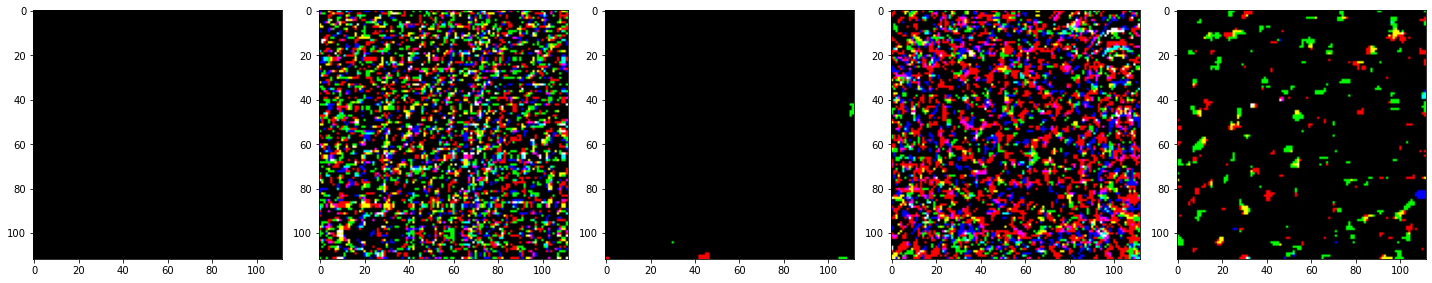

In [37]:
import matplotlib.pyplot as plt

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        img = (img*255).astype(np.uint8)
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
    
augmented_images = [train_data[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [38]:
for i,label in train_data:
  print(i.shape)
  print(label)
  break

print(train_data.class_indices.keys())
print(len(train_data.class_indices.keys()))

(64, 112, 112, 3)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
dict_keys(['t_id_0DPPpRUz', 't_id_0g31STvR', 't_id_15bo4NKD', 't_id_1KIezxkh', 't_id_2E8o5Jtl', 't_id_2QmcRkNj', 't_id_2Yn71r7R', 't_id_3K93fQBS', 't_id_3b65X5Lw', 't_id_3fKmnkBS', 't_id_4XiPKIk7', 't_id_4ZfTUmwL', 't_id_72SiiZCp', 't_id_7gFFZy7i', 't_id_87CLFCvE', 't_id_8b8sprYe', 't_id_9GFmcOd5', 't_id_AMnriNb5', 't_id_AOWArhGb', 't_id_B7LaSiac', 't_id_BI99coHt', 't_id_BXWccqAn', 't_id_C0wevyOl', 't_id_D0gA44av', 't_id_D3kHUEgp', 't_id_D7NA71la', 't_id_DPYQnZyv', 't_id_DbmclTcj', 't_id_Dv4O8bOM', 't_id_EEbWq5Pj', 't_id_FBsGDJhU', 't_id_G5JLzvai', 't_id_G5eoqwD8', 't_id_GOIvCduN', 't_id_GrxmyS59', 't_id_HcnnlRda', 't_id_HxxqrdTx', 't_id_IP1t15lD', 't_id_IP3xtKuX', 't_id_IlO9BOKc', 't_id_Imm5pnNf', 't_id_J24awAHQ', 't_id_J5dngbNA', 't_id_JI6ba2Yx', 't_id_Kc1tXDbJ', 't_id_Kf73l69A', 't_id_KysHzQQK', 't_id_Lhp87PBX',

In [39]:
## Load model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import copy

num_classes = 100

#tf.keras.applications.resnet.ResNet152
model_res = tf.keras.applications.densenet.DenseNet169(
    include_top= False, weights='imagenet', input_shape=(112,112,3),
)

model_res.trainable = True

# # Create new model on top.
# inputs = keras.Input(shape=(112, 112,3))
# x = model(inputs)
# x = model_res(x, training=True)
# outputs = keras.layers.Dense(num_classes)(x)
# model = keras.Model(inputs, outputs)


inputs = keras.Input(shape=(112, 112, 3))
inputs = tf.keras.applications.densenet.preprocess_input(inputs)
# inputs = tf.keras.applications.resnet_v2.preprocess_input(inputs)
x1 = model_res(inputs, training=True)
x = keras.layers.GlobalAveragePooling2D()(model_res.output)
outputs = keras.layers.Dense(num_classes, activation='softmax') (x)
model = keras.Model(inputs = model_res.input , outputs = outputs)

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 118, 118, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 56, 56, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 56, 56, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
import cv2
# opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100)

model.compile(
  optimizer=opt,
  loss=tf.losses.CategoricalCrossentropy(), #from_logits=True),
  metrics=['accuracy'])

history = model.fit(
  train_data,
  validation_data=val_data,
  epochs=35,
  callbacks = [rlrop]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 161 steps, validate for 5 steps
Epoch 1/35
161/161 [==============================] - 384s 2s/step - loss: 4.9384 - accuracy: 0.0098 - val_loss: 19055.7371 - val_accuracy: 0.0072
Epoch 2/35
 75/161 [============>.................] - ETA: 3:10 - loss: 4.7876 - accuracy: 0.0088

In [ ]:
history = model.fit(
  train_data,
  validation_data=val_data,
  epochs=10,
  callbacks = [rlrop]
)

### Model Evaluation

In [ ]:
test_data = val_data
model.evaluate(test_data,
#                batch_size=64,
               use_multiprocessing=True)
 
model.save_weights('./weights4')  #weight3(model_2) is 35epoch(album w/o impol)
model.save('./model_3')

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Checking model with mapk

In [ ]:
# import tensorflow as tf
# from tensorflow import keras

# # tf.keras.backend.clear_session()
# # from numba import cuda
# # cuda.select_device(0)
# # cuda.close()
# model = keras.models.load_model('/kaggle/working/model_1')

##alternativ model weights
##model.load_weights('./weights')

In [ ]:
# def crop_center(img):
#     y,x, _ = img.shape
#     crop_size = min(y,x)
# #     print(crop_size)
    
#     x_start = (x - crop_size) // 2
#     x_end = (x + crop_size) // 2
#     y_start = (y - crop_size) // 2
#     y_end = (y + crop_size) // 2
# #     print("startx = {}  endx = {}".format(x_start, x_end))
# #     print("starty = {}  endy = {}".format(y_start, y_end))
#     crop_img = img[y_start:y_end, x_start:x_end]
# #     print(crop_img.shape)
#     res = cv2.resize(crop_img, dsize=(112, 112), interpolation=cv2.INTER_LINEAR)
#     return res

In [ ]:
import cv2
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset = pd.read_csv('./dataset.csv')
test_ds = dataset.loc[dataset['type'] == "val"]

In [ ]:
def our_preprocessing_function(filename):
    #Combines all the 
    crop = crop_center(filename)
#     final_img = signal.wiener(crop,3)
    final_img = crop
    return final_img

test_gen = ImageDataGenerator(
    rescale = 1./255,
    preprocessing_function = val_preprocessing_function
)

test_data = test_gen.flow_from_dataframe(val_ds, x_col='image_id', y_col='turtle_id', seed = 42, batch_size = 64, shuffle = False, class_mode="categorical", target_size = (112,112))

In [ ]:
def apk(actual, predicted, k=5):
  """Computes the average precision at k.

  Args:
    actual: The turtle ID to be predicted.
    predicted : A list of predicted turtle IDs (order does matter).
    k : The maximum number of predicted elements.

  Returns:
    The average precision at k.
  """
  if len(predicted) > k:
    predicted = predicted[:k]
    

  score = 0.0
  num_hits = 0.0

  for i, p in enumerate(predicted):
    if p == actual and p not in predicted[:i]:
      num_hits += 1.0
      score += num_hits / (i + 1.0)

  return score

def mapk(actual, predicted, k=5):
  """ Computes the mean average precision at k.

    The turtle ID at actual[i] will be used to score predicted[i][:k] so order
    matters throughout!

    actual: A list of the true turtle IDs to score against.
    predicted: A list of lists of predicted turtle IDs.
    k: The size of the window to score within.

    Returns:
      The mean average precision at k.
  """
  return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

# # print(len(img_list))
# # img_list = np.array(img_list)
# # print(img_list.shape)
# # y_pred = model.predict(img_list, use_multiprocessing=True)
# # print(y_pred.shape)
# # print(y_pred)

In [ ]:
import torch
def test_model(model, img_list):

    y_pred = model.predict(img_list, use_multiprocessing=True)   # Set model to evaluate mode
#     print(y_pred)
    t_output = []
    t_pred = []
    y_test = []
    top_k = []
    image_id = []
    for inputs in y_pred:
        inputs = torch.Tensor(inputs)
        t_output.append(inputs)
        temp1, temp2 = inputs.topk(5) #might break here
        top_k.append(temp2.tolist())
    return top_k

top_k_indices = test_model(model, test_data)
top_k_indices

In [ ]:
label_map = (test_data.class_indices)
inv_map = {v: k for k, v in label_map.items()}

y_pred_labels = np.empty((len(top_k_indices), 5), dtype=np.dtype('U13'))
for j in range(0, len(top_k_indices)):
    for i in range(0,5):
        y_pred_labels[j][i] = inv_map[top_k_indices[j][i]]
print(y_pred_labels)
trueTurtles = test_ds['turtle_id'].tolist()
print(len(trueTurtles))

In [ ]:
mapk_result = mapk(trueTurtles, y_pred_labels, k=5)
print("With real set labels, our mapk with k=5 is", mapk_result)

# from sklearn.metrics import accuracy_score
# print("Accuracy:", accuracy_score(trueTurtles, y_pred_labels[:,0]))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import scikitplot as skplt

print(y_pred_labels.shape)
print(len(trueTurtles))

y_pred_labels = pd.DataFrame(y_pred_labels)

y_pred_top = [y_pred_labels.iloc[i][y_pred_labels.iloc[i]==(trueTurtles[i])].to_dict() for i in range(0,y_pred_labels.shape[0])]
# print(y_pred_top)
y_pred_top = [(list(i.values())+['new_turtle'])[0] for i in y_pred_top]
# print(y_pred_top)
# print(trueTurtles)

In [ ]:
# cm = confusion_matrix(trueTurtles, y_pred_top)
# disp= ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = label_map.keys())
# plt.xticks(rotation=90, fontsize = 'xx-small')
# disp.plot()

skplt.metrics.plot_confusion_matrix(trueTurtles, y_pred_top, title='', x_tick_rotation=90, normalize=True, figsize=(15,10), text_fontsize='xx-small', hide_counts=True)
plt.show()
# plt.close('all')

## **Submission Code**

In [ ]:
##Submission
import urllib
import requests
import io
def read_csv_from_web(file_name):
  url = urllib.parse.urljoin('https://storage.googleapis.com/dm-turtle-recall/', file_name)
  content = requests.get(url).content
  return pd.read_csv(io.StringIO(content.decode('utf-8')))


test = read_csv_from_web('test.csv')
test['image_id'] = './turtle_recall/images' + "/" + test['image_id'].astype(str) + ".JPG"
test.head()

test_gen = ImageDataGenerator(
    rescale = 1./255,
    preprocessing_function = val_preprocessing_function
)

test_data = test_gen.flow_from_dataframe(test, x_col='image_id', y_col= None, seed = 42, batch_size = 32, shuffle = False, class_mode=None, target_size = (112,112))
top_k_indices = test_model(model, test_data)

label_map = (train_data.class_indices)
inv_map = {v: k for k, v in label_map.items()}

y_pred_labels = np.empty((len(top_k_indices), 5), dtype=np.dtype('U13'))
for j in range(0, len(top_k_indices)):
    for i in range(0,5):
        y_pred_labels[j][i] = inv_map[top_k_indices[j][i]]
print(y_pred_labels)

In [ ]:
output_df = pd.DataFrame({'image_id': test['image_id'].tolist(), 
                          'prediction1': y_pred_labels[:,0], 
                          'prediction2': y_pred_labels[:,1], 
                          'prediction3': y_pred_labels[:,2], 
                          'prediction4': y_pred_labels[:,3], 
                          'prediction5': y_pred_labels[:,4]})
output_df['image_id'] = output_df['image_id'].apply(lambda x: x.split('/')[-1].split('.')[0])
output_df.head()

In [ ]:
output_df.to_csv('./output.csv', index=False)